<a href="https://colab.research.google.com/github/MatthiasM086/Track/blob/master/self_driving_car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [117]:
!git clone https://github.com/MatthiasM086/Track

fatal: destination path 'Track' already exists and is not an empty directory.


In [121]:
#%cd /content/Track/
#!git pull

/content/Track
remote: Enumerating objects: 2104, done.
remote: Counting objects: 100% (2104/2104), done.
remote: Compressing objects: 100% (2102/2102), done.
remote: Total 2104 (delta 2), reused 2104 (delta 2), pack-reused 0
Receiving objects: 100% (2104/2104), 25.50 MiB | 3.41 MiB/s, done.
Resolving deltas: 100% (2/2), completed with 2 local objects.
From https://github.com/MatthiasM086/Track
   236314a4..e4536fe5 master     -> origin/master
Updating 236314a4..e4536fe5
Fast-forward
 IMG/center_2020_11_23_14_49_04_728.jpg | Bin 0 -> 12140 bytes
 IMG/center_2020_11_23_14_49_04_829.jpg | Bin 0 -> 12146 bytes
 IMG/center_2020_11_23_14_49_04_930.jpg | Bin 0 -> 12133 bytes
 IMG/center_2020_11_23_14_49_05_032.jpg | Bin 0 -> 12137 bytes
 IMG/center_2020_11_23_14_49_05_134.jpg | Bin 0 -> 12133 bytes
 IMG/center_2020_11_23_14_49_05_236.jpg | Bin 0 -> 12145 bytes
 IMG/center_2020_11_23_14_49_05_337.jpg | Bin 0 -> 12138 bytes
 IMG/center_2020_11_23_14_49_05_438.jpg | Bin 0 -> 12136 bytes
 IMG/ce

In [123]:
%cd /content/

/content


In [124]:
!ls Track

driving_log.csv  IMG


In [127]:
!pip3 install imgaug

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
import cv2
import pandas as pd
import random 
import os
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from imgaug import augmenters as iaa

In [129]:
datadir = "Track"
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth',-1)
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


center  ...     speed
0  D:\Sandbox\self_driving_car\Data\IMG\center_2020_09_26_14_34_52_491.jpg  ...  0.000023
1  D:\Sandbox\self_driving_car\Data\IMG\center_2020_09_26_14_34_52_592.jpg  ...  0.000022
2  D:\Sandbox\self_driving_car\Data\IMG\center_2020_09_26_14_34_52_695.jpg  ...  0.000022
3  D:\Sandbox\self_driving_car\Data\IMG\center_2020_09_26_14_34_52_797.jpg  ...  0.000022
4  D:\Sandbox\self_driving_car\Data\IMG\center_2020_09_26_14_34_52_899.jpg  ...  0.000022

[5 rows x 7 columns]

In [130]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['left'].apply(path_leaf)

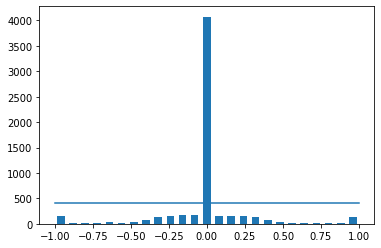

In [131]:
num_bins =  25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data:  5982
removed:  3674
remaining:  2308


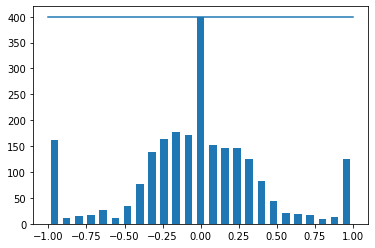

In [132]:
print('total data: ', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed: ', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining: ', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [133]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths , steerings = load_img_steering(datadir + '/IMG', data)

center      center_2020_09_26_14_34_53_202.jpg
left        left_2020_09_26_14_34_53_202.jpg  
right       left_2020_09_26_14_34_53_202.jpg  
steering    0                                 
throttle    0                                 
reverse     0                                 
speed       2.44053e-05                       
Name: 7, dtype: object


In [134]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)

print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 1846
Valid Samples: 462


Text(0.5, 1.0, 'Validation set')

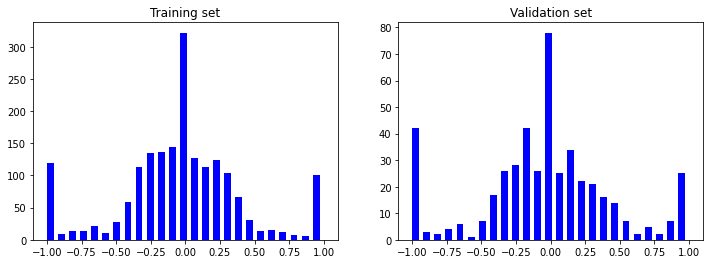

In [135]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))
axes[0].hist(y_train, bins=num_bins, width = 0.05, color = 'blue')
axes[0].set_title('Training set')

axes[1].hist(y_valid, bins=num_bins, width = 0.05, color = 'blue')
axes[1].set_title('Validation set')

In [136]:
def zoom(image):
  zoom = iaa.Affine(scale=(1,1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed Image')

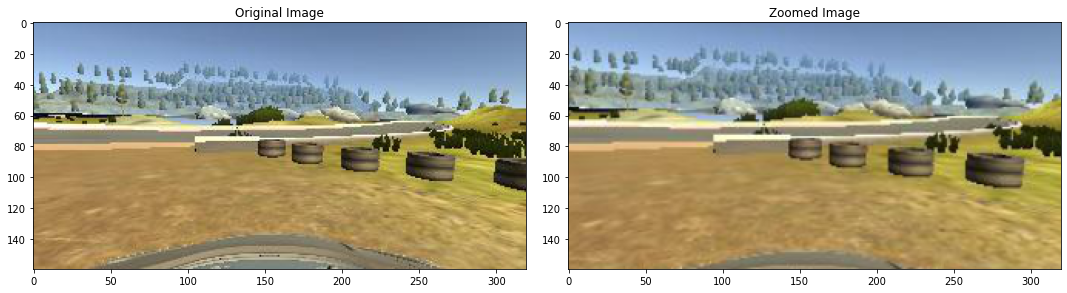

In [137]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')

axes[1].imshow(zoomed_image)
axes[1].set_title('Zoomed Image')

In [138]:
def pan(image):
  pan = iaa.Affine(translate_percent= {'x' : (-0.1, 0.1), 'y' : (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned Image')

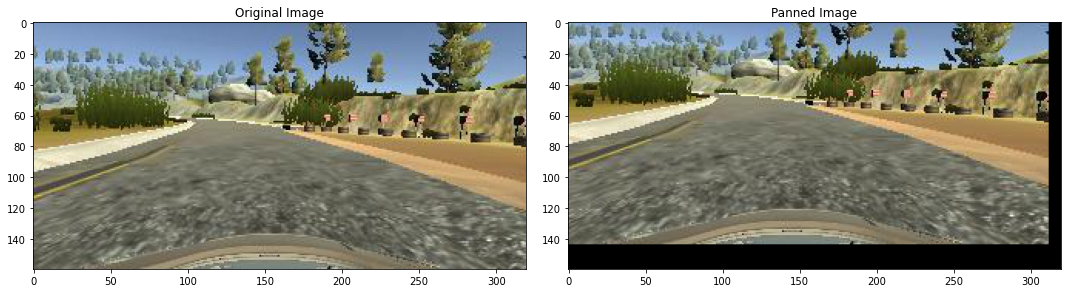

In [139]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')

axes[1].imshow(panned_image)
axes[1].set_title('Panned Image')

In [140]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'Bright Image')

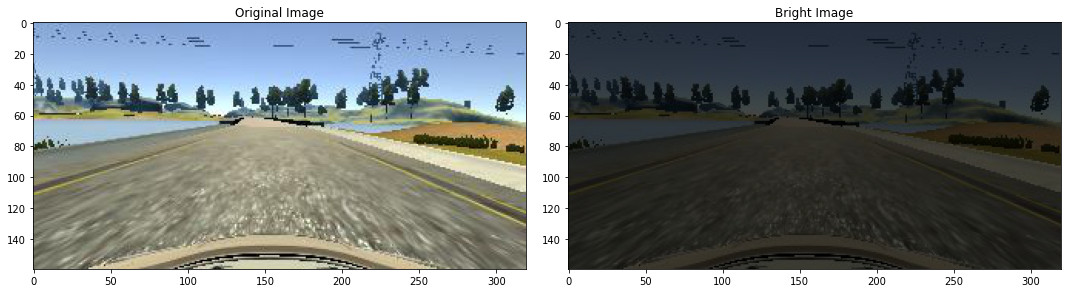

In [141]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')

axes[1].imshow(brightness_altered_image)
axes[1].set_title('Bright Image')

In [142]:
def img_random_flip(image, steering_angle):
  image =  cv2.flip(image, 1)
  steering_angle = -steering_angle
  return image, steering_angle

Text(0.5, 1.0, 'Flipped Image - Flipped Steering Angle 0.3171492')

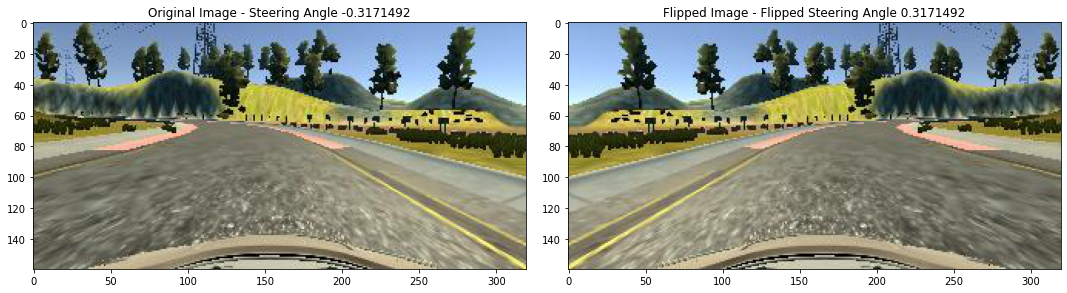

In [143]:
random_index = random.randint(0,1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image - ' + 'Steering Angle ' + str(steering_angle))

axes[1].imshow(flipped_image)
axes[1].set_title('Flipped Image - ' + 'Flipped Steering Angle ' + str(flipped_steering_angle))

In [144]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)
  return image, steering_angle

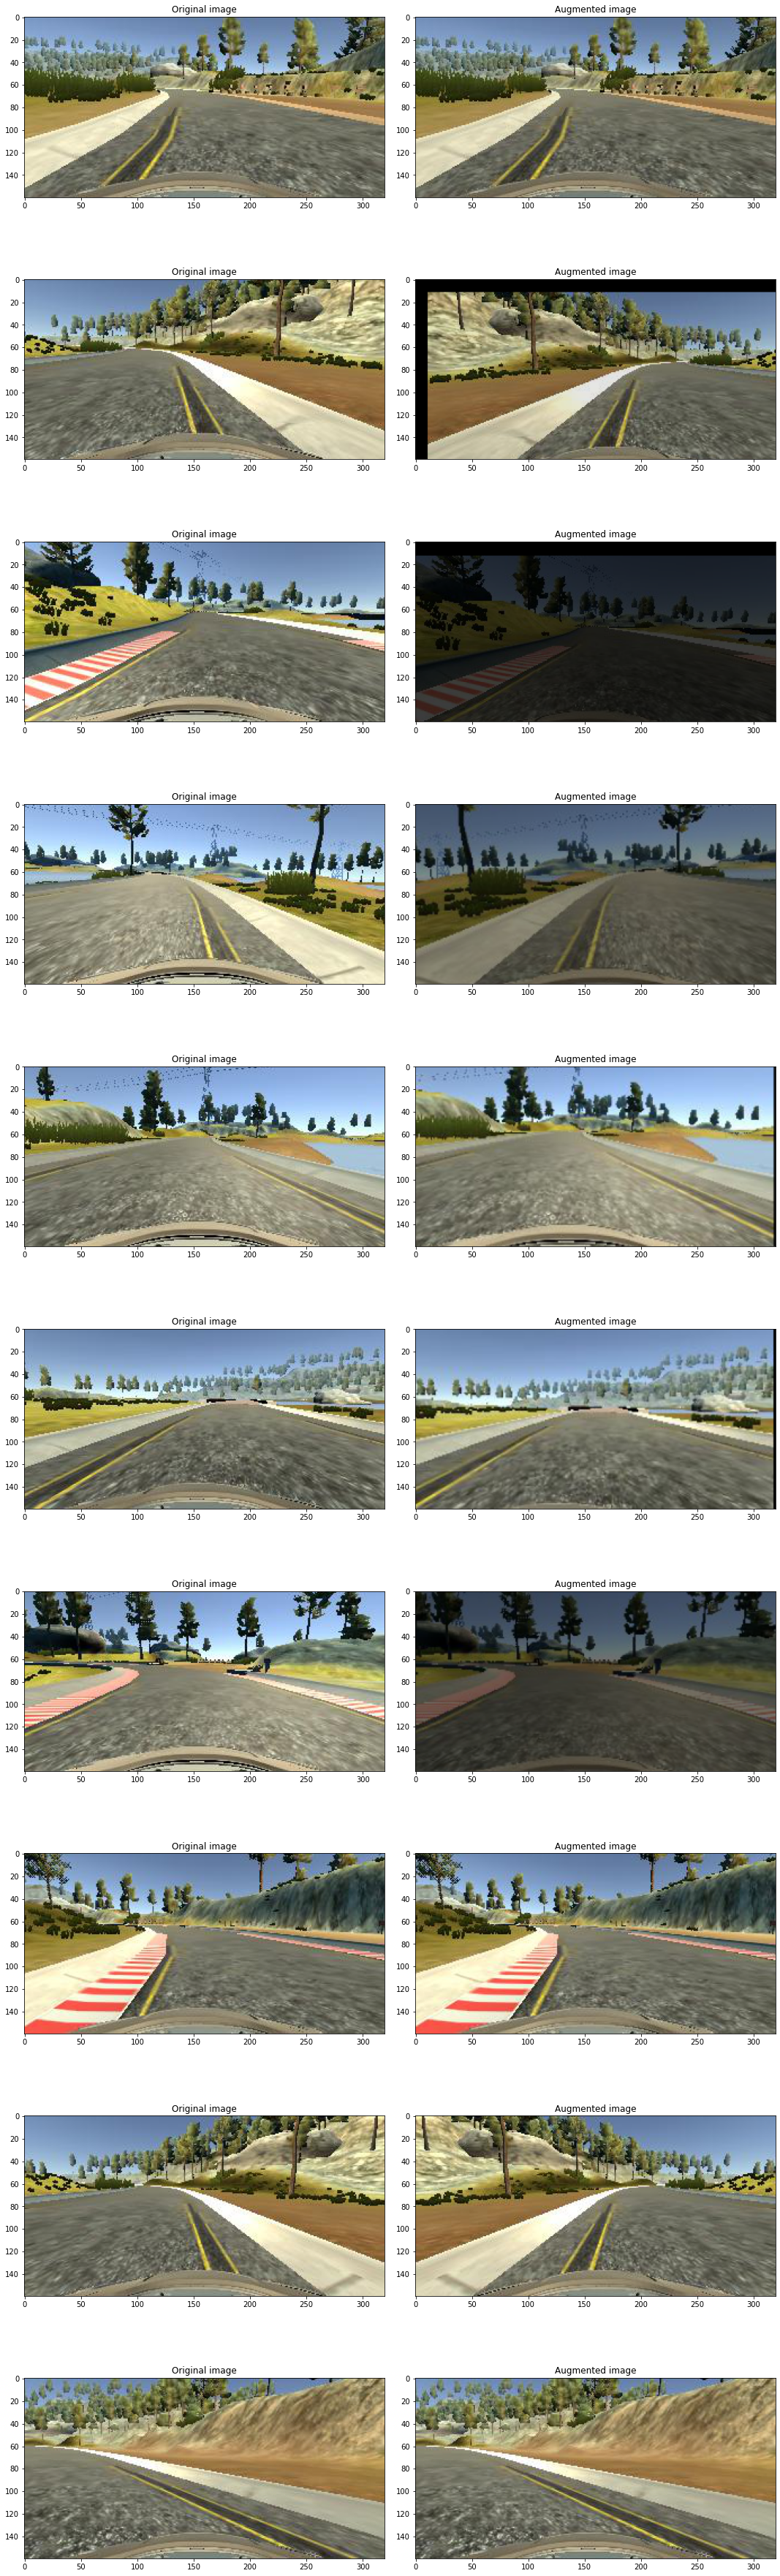

In [145]:
ncol = 2
nrow = 10

fig, axe = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths)-1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]

  original_image = mpimg.imread(random_image)
  augmented_image, steering =  random_augment(random_image, random_steering)

  axe[i][0].imshow(original_image)
  axe[i][0].set_title('Original image')

  axe[i][1].imshow(augmented_image)
  axe[i][1].set_title('Augmented image')



In [146]:
def img_preprocess(img):
  #img = mpimg.imread(img)
  img = img[60:135, :, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img,(3,3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

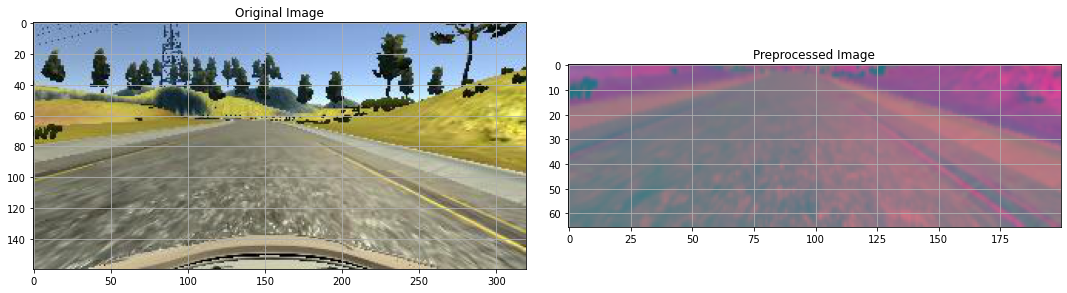

In [149]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axe = plt.subplots(1, 2, figsize= (15,10))
fig.tight_layout()
axe[0].imshow(original_image)
axe[0].set_title("Original Image")
axe[0].grid()
axe[1].imshow(preprocessed_image)
axe[1].set_title("Preprocessed Image")
axe[1].grid()

In [150]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)

      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))


Text(0.5, 1.0, 'Validation Image')

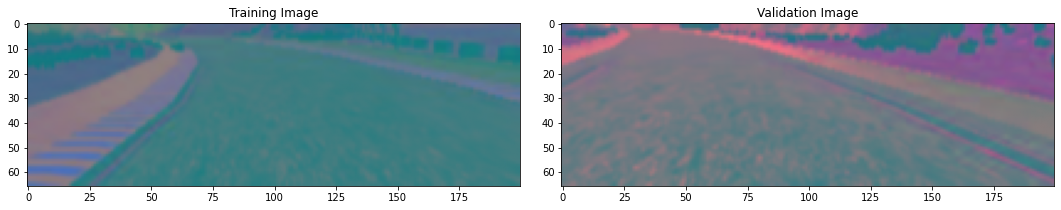

In [151]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1 , 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1 , 0))

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axes[0].imshow(x_train_gen[0])
axes[0].set_title('Training Image')

axes[1].imshow(x_valid_gen[0])
axes[1].set_title('Validation Image' )

In [152]:
#X_train = np.array(list(map(img_preprocess, X_train)))

In [153]:
#X_valid = np.array(list(map(img_preprocess, X_valid)))

In [154]:
#plt.imshow(X_train[random.randint(0, len(X_train)-1)])
#plt.axis('off')
#print(X_train.shape)

In [155]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3), activation='elu'))
  model.add(Convolution2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Convolution2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Convolution2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Convolution2D(64, kernel_size=(3,3), activation='elu'))
  # model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(100, activation = 'elu'))
  # model.add(Dropout(0.5))

  model.add(Dense(50, activation = 'elu'))
  # model.add(Dropout(0.5))

  model.add(Dense(10, activation = 'elu'))
  # model.add(Dropout(0.5))
  
  model.add(Dense(1))

  optimizers = Adam(lr=1e-4)
  model.compile(loss = 'mse', optimizer=optimizers)

  return model

In [156]:
model = nvidia_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)              

In [157]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1), 
                              steps_per_epoch = 300, 
                              epochs = 10, 
                              validation_data = batch_generator(X_valid, y_valid, 100, 0), 
                              validation_steps = 200, 
                              verbose = 1, 
                              shuffle = 1 ) 

Epoch 1/10
300/300 [==============================] - 376s 1s/step - loss: 0.1640 - val_loss: 0.1726
Epoch 2/10
300/300 [==============================] - 377s 1s/step - loss: 0.1455 - val_loss: 0.1537
Epoch 3/10
300/300 [==============================] - 377s 1s/step - loss: 0.1263 - val_loss: 0.1242
Epoch 4/10
300/300 [==============================] - 378s 1s/step - loss: 0.1149 - val_loss: 0.1072
Epoch 5/10
300/300 [==============================] - 378s 1s/step - loss: 0.1068 - val_loss: 0.1091
Epoch 6/10
300/300 [==============================] - 373s 1s/step - loss: 0.0970 - val_loss: 0.1003
Epoch 7/10
300/300 [==============================] - 373s 1s/step - loss: 0.0953 - val_loss: 0.0989
Epoch 8/10
300/300 [==============================] - 373s 1s/step - loss: 0.0900 - val_loss: 0.0877
Epoch 9/10
300/300 [==============================] - 375s 1s/step - loss: 0.0867 - val_loss: 0.0831
Epoch 10/10
300/300 [==============================] - 371s 1s/step - loss: 0.0834 - val_lo

(-0.45, 9.45, 0.07191840074956417, 0.17740391679108142)

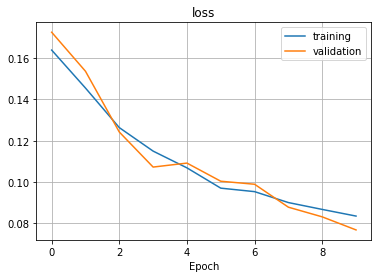

In [158]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('Epoch')
plt.grid()
plt.axis()

In [159]:
model.save('model.h5')

In [160]:
from google.colab import files

In [161]:
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>